In [1]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as LN
import networkx as nx
import copy
from scipy.optimize import minimize

from progressbar import ProgressBar

# =========================================================================== #
#コード作成の順番
"""
1: Agent_subgrad(object)のclassを作る
2: 各パラメータの値を決定
3: agentの関数の決定．
4: 固定連結無向グラフを作成・プロット
5: 重み行列の決定
6: Initialization
7: Plot the initial estimation
8: アルゴリズムの構築
9: グラフのプロット
10: 収束しているかの確認

目的関数
    F(z) = F_1(z) + F_2(z) + F_3(z)
    F_1(z) = 2z^2
    F_2(z) = 3z~2 + 2z
    F_3(z) = 4z^2 + 2
"""
# =========================================================================== #
#classの設定
class Agent_gradient(object):
    #def __init__() : エージェントの勾配に必要な，変数をAgent_gradient classが持つself変数に代入する
    def __init__(self, N, n, weight, name, stepsize, eventtrigger):
        self.N = N #agentの数
        self.n = n #agentの持つ変数の次元
        #self.agent = agent #agentの持つ費用関数を渡す
        self.name = name
        self.weight = weight
        self.stepsize = stepsize
        self.eventtrigger = eventtrigger

        self.initial_state()

    #Initialization : agentの初期状態を決定する
    def initial_state(self):
        self.z_i = np.random.random_integers(-3, 6) #agentのcost functionの決定変数
        self.z = np.zeros([self.N, self.n])
        self.z_send = np.zeros([self.N, self.n])
        
    #Compute the gradient 非凸での勾配を考える．
    def grad(self, i, x):
        if i == 0:
            return (-3*2*x*(x+2)-3*(x**2-16))
        elif i == 1:
            return ((1.5*x**2+2*x)*(x-4)+(0.5*x**3+x**2))
        elif i == 2:
            return ((2*(x+4)+(x+4)**2))
    
    #Compute the step-size
    def step_size(self, t, stepsize):
        return stepsize / (t+1)

    #Send the state to the neighbor agents　
    def send(self, j):
        self.z_send[j] = self.z_i
        return self.z_i, self.name
    
    #Receive the states from the neighbor agents
    def receive(self, z_j, name):
        self.z[name] = z_j
        
    #Compute the event_trigger_figure(閾値) eventtrigger / (t+1)
    def event_trigger(self, t, eventrigger):
        return eventrigger / (t + 1)
    
    #Update the state by the distributed subgradient algorithm
    def update(self, t):
        self.diff = self.z - self.z_send
        self.z_i = self.z_i + np.dot(self.weight, self.diff)  - self.step_size(t, self.stepsize) * self.grad(i = self.name, x = self.z_i)
        self.z_send[self.name] = self.z_i
        self.z[self.name] = self.z_i
        
#目的関数
def objective_funcition(x):
    return (-4*(x**2-16)*(x+4) + ((x**3+x**2)*(x-4)) + ((x+4)**2)*(x-4))

# ============================================================================= #
#Parameters

#Number of agents
N = 3

#Number of dimensions of the decision variable
n = 1

#Coefficient of decision of stepsize : a(t) = a / t
stepsize = 0.013

        
# Coefficient of the edge weight  w_if = wc / max_degree
wc = 0.8

#Number of iterations
iteration = 1000

# Interval for figure plot 
fig_interval = 200

# plot region
x_min = -6
x_max = 6

#Coefficient of decision of stepsize : E_ij(t) = E(t) = eventtrigger / (t+1)
eventtrigger = [0, 0.1, 0.15]

# Randomization seed
np.random.seed(0)

# ============================================================================= #
# Communication Graph
A = np.array(
    [[1, 1, 1],
     [1, 1, 0],
     [1, 0, 1]])

G = nx.from_numpy_matrix(A)


# Weighted Stochastic Matrix P
a = np.zeros(N)

for i in range(N):
    a[i] = copy.copy(wc / nx.degree(G)[i])

P = np.zeros((N, N))
for i in range(N):
    for j in range(i, N):
        if i != j and A[i][j] == 1:
            a_ij = min(a[i], a[j])
            P[i][j] = copy.copy(a_ij)
            P[j][i] = copy.copy(a_ij)

for i in range(N):
    sum = 0.0
    for j in range(N):
        sum += P[i][j]
    P[i][i] = 1.0 - sum
# ============================================================================= #
#scipyを用いてobjective_function の局所解を求める
x1 = -3.0
x2 = 2
b = (-5.0, 8.0)
sol1 = minimize(objective_funcition, x1, method='nelder-mead', bounds=b)
sol2= minimize(objective_funcition, x2, method='nelder-mead', bounds=b)
sol = [sol1, sol2]

#Agentsの初期状態を統一する
Agent_array = []
initial_state_array = []
for i in range(N):
    Agent_array.append(Agent_gradient(N, n, P[i], i, stepsize, eventtrigger))
    initial_state_array.append(Agent_array[i].z_i)
print(initial_state_array)

#plot時の評価指標に用いる配列
tmp_diff_estim_array = [[], [], []] #Agentの見積もり状態をいれる配列
    
#Algorithm 
for e in range(len(eventtrigger)): #eventtigger と　stepsize の行列から要素を指定
    #initialization
    Agents = copy.deepcopy(Agent_array)
    
    z0 = [np.linspace(x_min, x_max) for i in range(N)]

    prog = ProgressBar(max_value=iteration)
    
    print('E =', Agents[0].eventtrigger[e])
    
    for i in range(N):
        for j in range(N):
            #Send the state to the neighbor agents at initial time 
            state, name = Agents[i].send(j)

            #Receive the state from the neighbor agents at initial time
            Agents[j].receive(state, name)

    for t in range(iteration):    
     
        prog.update(t)
        
        sum_diff_at_t = 0
        for agent in Agents:
            sum_diff_at_t += np.abs(objective_funcition(agent.z_i) - sol[1].fun)
        tmp_diff_estim_array[e].append(sum_diff_at_t)
        
        # ============================================================================= #
        # Transfer data among agents
        for i in range(N):
            for j in range(N):
                if j != i:
                    if LN.norm(Agents[i].z_i - Agents[i].z_send[j], ord=1) > Agents[i].event_trigger(t+1, Agents[i].eventtrigger[e]):
                        #Send the state to the neighbor agents
                        state, name = Agents[i].send(j)
                        #Receive the state from the neighbor agents
                        Agents[j].receive(state, name)

        # Update the state
        for i in range(N):
            Agents[i].update(t+1)
        
    print('Agents condition after iteration')
    for i in range(N):
        print('Agents', i, Agents[i].z_i)

    tmp_local_minima = sol[1]
        
    print('objective function : {}'.format(tmp_local_minima.fun))

    print('objective function estimated by Agent | 1:{}, 2:{}, 3:{}'.format(objective_funcition(Agents[0].z_i), objective_funcition(Agents[1].z_i), objective_funcition(Agents[2].z_i)))
    
    diff = 0 
    
    for agent in Agents:
        diff += np.abs(tmp_local_minima.fun-objective_funcition(agent.z_i))
    
    print('difference : {}'.format(diff))
    

C:\Users\Adachi Takashi\Anaconda3\lib\site-packages\scipy\optimize\_minimize.py:517: RuntimeWarning: Method nelder-mead cannot handle constraints nor bounds.
  RuntimeWarning)
C:\Users\Adachi Takashi\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: DeprecationWarning: This function is deprecated. Please call randint(-3, 6 + 1) instead
 16% (165 of 1000) |###                  | Elapsed Time: 0:00:00 ETA:   0:00:09

[2, -3, 0]
E = 0


N/A% (0 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

Agents condition after iteration
Agents 0 [-1.85459057]
Agents 1 [-1.8531898]
Agents 2 [-1.85430378]
objective function : -111.36943474380195
objective function estimated by Agent | 1:[98.05101081], 2:[98.07898917], 3:[98.05672694]
difference : [628.29503116]
E = 0.1
Agents condition after iteration
Agents 0 [-1.85459188]
Agents 1 [-1.85319111]
Agents 2 [-1.85430509]
objective function : -111.36943474380195
objective function estimated by Agent | 1:[98.05098476], 2:[98.078963], 3:[98.05670085]
difference : [628.29495284]
E = 0.15


 93% (937 of 1000) |###################  | Elapsed Time: 0:00:00 ETA:   0:00:00

Agents condition after iteration
Agents 0 [-1.85451411]
Agents 1 [-1.85311337]
Agents 2 [-1.85422726]
objective function : -111.36943474380195
objective function estimated by Agent | 1:[98.05253418], 2:[98.08052002], 3:[98.05825305]
difference : [628.29961148]


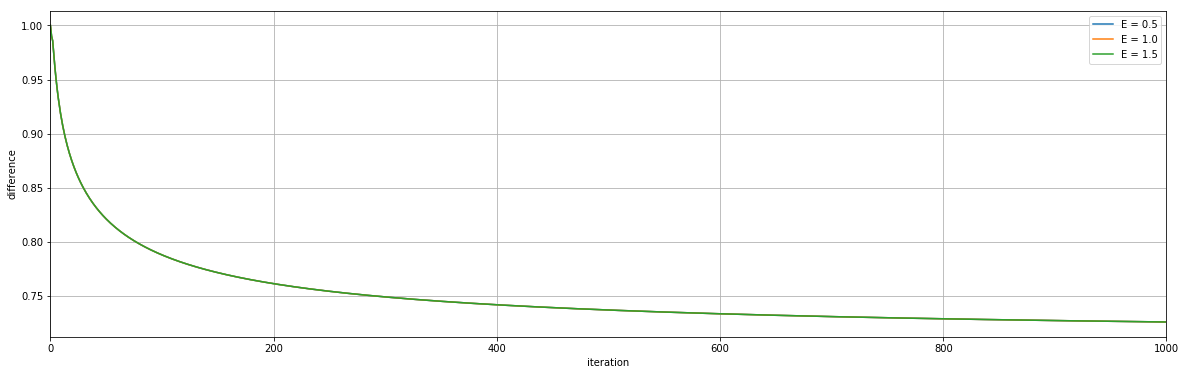

In [5]:
E_array = [0.5, 1.0, 1.5]

initial_object_state_diff = 0
for t in initial_state_array:
    initial_object_state_diff += np.abs(objective_funcition(t) - sol[1].fun)

# グラフの大きさを指定
plt.figure(figsize=(20, 6))
num_iteration = [i for i in range(iteration)]
# label= と　legendでラベルを付ける
for i in range(3):
    plt.plot(num_iteration, tmp_diff_estim_array[i]/initial_object_state_diff, label='E = {}'.format(E_array[i]))
plt.legend()

plt.xlim(0, 1000)

plt.xlabel('iteration')
plt.ylabel('difference')
plt.grid(True)
plt.show()

In [53]:
#Parameters

#Number of agents
N = 3

#Number of dimensions of the decision variable
n = 1

#Coefficient of decision of stepsize : a(t) = a / t
stepsize = 0.013

        
# Coefficient of the edge weight  w_if = wc / max_degree
wc = 0.8

#Number of iterations
iteration = 1000

# Interval for figure plot 
fig_interval = 1000

# plot region
x_min = -6
x_max = 6

#Coefficient of decision of stepsize : E_ij(t) = E(t) = eventtrigger / (t+1)
eventtrigger = [0, 4, 10]

# Randomization seed
np.random.seed(55)

# ============================================================================= #
# Communication Graph
A = np.array(
    [[1, 1, 1],
     [1, 1, 0],
     [1, 0, 1]])

G = nx.from_numpy_matrix(A)


# Weighted Stochastic Matrix P
a = np.zeros(N)

for i in range(N):
    a[i] = copy.copy(wc / nx.degree(G)[i])

P = np.zeros((N, N))
for i in range(N):
    for j in range(i, N):
        if i != j and A[i][j] == 1:
            a_ij = min(a[i], a[j])
            P[i][j] = copy.copy(a_ij)
            P[j][i] = copy.copy(a_ij)

for i in range(N):
    sum = 0.0
    for j in range(N):
        sum += P[i][j]
    P[i][i] = 1.0 - sum

#scipyを用いてobjective_function の局所解を求める
x1 = -3.0
x2 = 2
b = (-5.0, 8.0)
sol1 = minimize(objective_funcition, x1, method='nelder-mead', bounds=b)
sol2= minimize(objective_funcition, x2, method='nelder-mead', bounds=b)
sol = [sol1, sol2]

#Agentsの初期状態を統一する
Agent_array = []
initial_state_array = []
for i in range(N):
    Agent_array.append(Agent_gradient(N, n, P[i], i, stepsize, eventtrigger))
    initial_state_array.append(Agent_array[i].z_i)
print(initial_state_array)
tmp_diff_estim_array = [[], [], []]
    
#Algorithm 
for e in range(len(eventtrigger)): #eventtigger と　stepsize の行列から要素を指定
    count = 0 #何回計算行ったかを表す
    
    #initialization
    Agents = copy.deepcopy(Agent_array)
    
    z0 = [np.linspace(x_min, x_max) for i in range(N)]

    prog = ProgressBar(max_value=iteration)
    
    print('E =', Agents[0].eventtrigger[e])
    
    for i in range(N):
        for j in range(N):
            #Send the state to the neighbor agents at initial time 
            state, name = Agents[i].send(j)

            #Receive the state from the neighbor agents at initial time
            Agents[j].receive(state, name)

    for t in range(iteration):
        
        
        prog.update(t)
        
        sum_diff_at_t = 0
        for agent in Agents:
            sum_diff_at_t += np.abs(objective_funcition(agent.z_i) - sol[1].fun)
        tmp_diff_estim_array[e].append(sum_diff_at_t)
        
        count += 1
#         if np.abs(true_result-objective_funcition_for_agent([agent.z_i for agent in Agents])) < 0.005:
#             print('count :', count)
#             break
        # ============================================================================= #
        # Transfer data among agents
        for i in range(N):
            for j in range(N):
                if j != i:
                    if LN.norm(Agents[i].z_i - Agents[i].z_send[j], ord=1) > Agents[i].event_trigger(t+1, Agents[i].eventtrigger[e]):
                        #Send the state to the neighbor agents
                        state, name = Agents[i].send(j)
                        #Receive the state from the neighbor agents
                        Agents[j].receive(state, name)

        # Update the state
        
        for i in range(N):
    #         print('Agents', i, 'condition')
    #         print('勾配 :', Agents[i].grad(Agents[i].name, Agents[i].z_i), 'z :', Agents[i].z.T)
            Agents[i].update(t+1)
        
    print('Agents condition after iteration')
    for i in range(N):
        print('Agents', i, Agents[i].z_i)

    tmp_local_minima = sol[1]
        
    print('objective function : {}'.format(tmp_local_minima.fun))

    print('objective function estimated by Agent | 1:{}, 2:{}, 3:{}'.format(objective_funcition(Agents[0].z_i), objective_funcition(Agents[1].z_i), objective_funcition(Agents[2].z_i)))
    
    diff = 0 
    
    for agent in Agents:
        diff += np.abs(tmp_local_minima.fun-objective_funcition(agent.z_i))
    
    print('difference : {}'.format(diff))
    

C:\Users\Adachi Takashi\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: DeprecationWarning: This function is deprecated. Please call randint(-3, 6 + 1) instead
N/A% (0 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

[4, 5, 2]
E = 0
Agents condition after iteration
Agents 0 [4.76505764]
Agents 1 [4.75773277]
Agents 2 [4.7587219]
objective function : -111.36943474380195
objective function estimated by Agent | 1:[-76.18337514], 2:[-75.59254985], 3:[-75.67254788]
difference : [106.65983136]
E = 4


 70% (709 of 1000) |##############       | Elapsed Time: 0:00:00 ETA:   0:00:00

Agents condition after iteration
Agents 0 [4.84579595]
Agents 1 [4.83847232]
Agents 2 [4.83786827]
objective function : -111.36943474380195
objective function estimated by Agent | 1:[-82.44384752], 2:[-81.89559302], 3:[-81.85019405]
difference : [87.91866964]
E = 10
Agents condition after iteration
Agents 0 [5.24733122]
Agents 1 [5.23329909]
Agents 2 [5.24040666]
objective function : -111.36943474380195
objective function estimated by Agent | 1:[-105.42737449], 2:[-104.88895511], 3:[-105.16435538]
difference : [18.62761925]


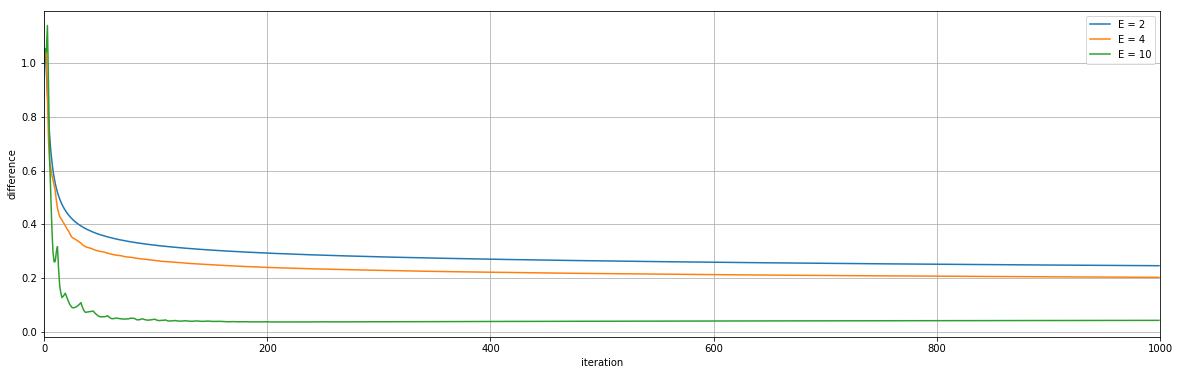

In [54]:
E_array = [2, 4, 10]

initial_object_state_diff = 0
for t in initial_state_array:
    initial_object_state_diff += np.abs(objective_funcition(t) - sol[1].fun)

# グラフの大きさを指定
plt.figure(figsize=(20, 6))
num_iteration = [i for i in range(iteration)]
# label= と　legendでラベルを付ける
for i in range(3):
    plt.plot(num_iteration, tmp_diff_estim_array[i]/initial_object_state_diff, label='E = {}'.format(E_array[i]))
plt.legend()

plt.xlim(0,1000)
plt.xlabel('iteration')
plt.ylabel('difference')
plt.grid(True)
plt.show()

In [3]:
print(tmp_diff_estim_array[0][-1])
print(tmp_diff_estim_array[1][-1])
print(tmp_diff_estim_array[2][-1])

[628.30540442]
[628.30532604]
[628.30998878]


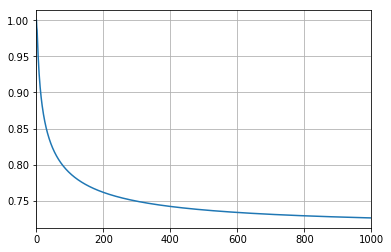

[0.72627369]
[0.72627899]


In [4]:
plt.plot(num_iteration, tmp_diff_estim_array[0]/initial_object_state_diff)
plt.xlim(0,1000)
plt.grid(True)
plt.show()

print(tmp_diff_estim_array[0][-1]/initial_object_state_diff)
print(tmp_diff_estim_array[2][-1]/initial_object_state_diff)